In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
from model import model_def

import json

from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

from tensorflow import keras


model = model_def()


datagen = ImageDataGenerator(rescale = 1/255., validation_split = 0.1)
batch_size = 128
img_height = 224
img_width = 224


train_data = datagen.flow_from_directory('/content/drive/MyDrive/Garbage/train/', class_mode='sparse', target_size=(img_height, img_width), batch_size=batch_size, shuffle = True, seed=42)
val_data = datagen.flow_from_directory('/content/drive/MyDrive/Garbage/valid/',class_mode='sparse', target_size=(img_height, img_width), batch_size=batch_size,
                                       shuffle=True, seed=42)

class_mappings = train_data.class_indices


with open("class_mappings.json", "w") as fp:
    json.dump(class_mappings , fp)


import os

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                           save_weights_only=True,
                           verbose=1)
# keras.optimizers.Adam(learning_rate=0.0003)

model.compile(loss = keras.losses.SparseCategoricalCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate = 0.0003),metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

history = model.fit(train_data,epochs = 100,validation_data = val_data,callbacks=[cp_callback])


# # Loads the weights
# model.load_weights(checkpoint_path)

# # Re-evaluate the model
# loss, acc = model.evaluate(test_images, test_labels, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 32)       128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, None, None, 32)       0         ['stem_bn[0][0]']         

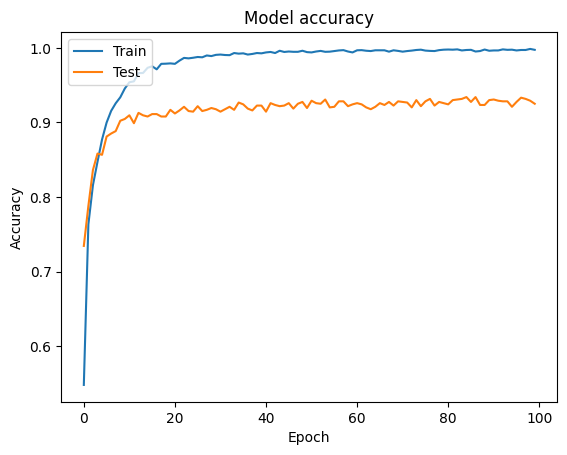

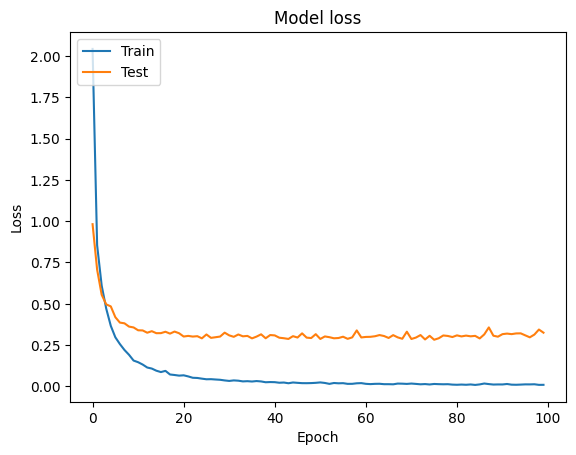

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

In [ ]:
from model import model_def
import tensorflow as tf

model = model_def()

checkpoint_path = "training_1/cp.ckpt"
model.load_weights(checkpoint_path)

model.save("model_saved.h5")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['input_3[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 32)       128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, None, None, 32)       0         ['stem_bn[0][0]']       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

from model import model_def

import pandas as pd


import json

from tensorflow.keras.utils import load_img, img_to_array


def infer(img):


    img_width, img_height = 224, 224
    img = load_img(img, target_size = (img_width, img_height))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)/255.

    ## Create Model Object
    model_path = 'model_saved.h5'
    model = keras.models.load_model(model_path)

    predicted_vector = model.predict(img,use_multiprocessing=True)

    #print(predicted_vector.shape)

    ## Convert the vector to list

    predicted_vector_list = predicted_vector.tolist()



    predicted_vector_list = sum(predicted_vector_list,[])

    ### Getting top 3 indices

    def sort_index(lst, rev=True):
        index = range(len(lst))
        s = sorted(index, reverse=rev, key=lambda i: lst[i])
        return s


    top_five= sort_index(predicted_vector_list)[:5]

    #print(top_five)
    with open('class_mappings.json') as json_file:
        data = json.load(json_file)

    data = {y: x for x, y in data.items()}

    list_of_predictions = []

    for index in top_five:
        list_of_predictions.append(data[index])

    top_five_values_prediction = sorted(predicted_vector_list,reverse=True)[:5]


    return(list_of_predictions, top_five_values_prediction)


In [ ]:
infer('/content/相片0013.jpg')

1/1 [==============================] - 2s 2s/step


(['tetra_pak', 'cardboard', 'metal', 'plastic', 'paper'],
 [0.9999494552612305,
  2.3848771888879128e-05,
  1.2117558071622625e-05,
  1.1578687008295674e-05,
  2.290968268425786e-06])